In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(37)

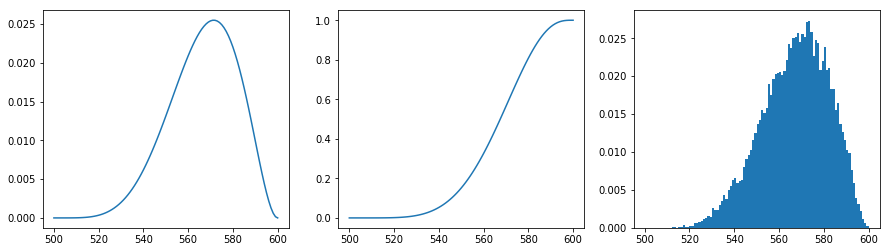

In [48]:
from scipy.special import gamma
from numpy.random import uniform

class Beta(object):
    @staticmethod
    def get_pdf(x, a, b, theta_1, theta_2):
        p = gamma(theta_1 + theta_2)
        p = p / gamma(theta_1)
        p = p / gamma(theta_2)
        p = p / (b - a)**(theta_1 + theta_2 - 1)
        p = p * (x - a)**(theta_1 - 1)
        p = p * (b - x)**(theta_2 - 1)
        return p

    @staticmethod
    def get_cdf(a, b, theta_1, theta_2):
        p = np.array([Beta.get_pdf(x, a, b, theta_1, theta_2) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    @staticmethod
    def get_samples(a, b, theta_1, theta_2, size=1):
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = Beta.get_cdf(a, b, theta_1, theta_2)
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)
    
a, b = 500, 600
theta_1, theta_2 = 6, 3

p = [Beta.get_pdf(x, a, b, theta_1, theta_2) for x in range(a, b+1)]
c = Beta.get_cdf(a, b, theta_1, theta_2)
s = Beta.get_samples(a, b, theta_1, theta_2, size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)

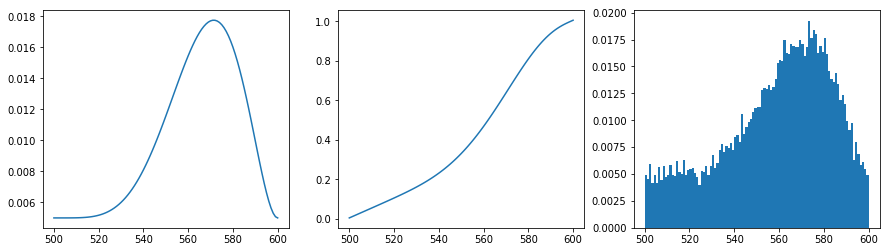

In [49]:
class BetaRect(object):
    @staticmethod
    def get_pdf(x, a, b, theta_1, theta_2, theta):
        p = gamma(theta_1 + theta_2)
        p = p / gamma(theta_1)
        p = p / gamma(theta_2)
        p = p / (b - a)**(theta_1 + theta_2 - 1)
        p = p * (x - a)**(theta_1 - 1)
        p = p * (b - x)**(theta_2 - 1)
        p = p * theta
        p = p + ((1 - theta) / (b - a))
        return p

    @staticmethod
    def get_cdf(a, b, theta_1, theta_2, theta):
        p = np.array([BetaRect.get_pdf(x, a, b, theta_1, theta_2, theta) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    @staticmethod
    def get_samples(a, b, theta_1, theta_2, theta, size=1):
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = BetaRect.get_cdf(a, b, theta_1, theta_2, theta)
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)

a, b = 500, 600
theta_1, theta_2 = 6, 3
theta = 0.5

p = [BetaRect.get_pdf(x, a, b, theta_1, theta_2, theta) for x in range(a, b+1)]
c = BetaRect.get_cdf(a, b, theta_1, theta_2, theta)
s = BetaRect.get_samples(a, b, theta_1, theta_2, theta, size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)